# Libaries

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# Load Data

In [6]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

In [8]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [9]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

## Create dataloaders

In [20]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

# Define a Convolutional Model

## Explaining convolutions

Images loaded with MNIST dataset are single colour channel so the in-channel will be one.

In [25]:
# Create two convolutions. Out channels were chosen at random
conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
conv2 = nn.Conv2d(6,16,3,1)

In [26]:
# Extract a single image from train data
X_train, y_train = train_data[0]

The convolution expects a batch of one channel so we need to reshape the data to provide the required shape = `[1,1,28,28]`

In [29]:
x = X_train.view(1,1,28,28)
x.shape

torch.Size([1, 1, 28, 28])

In [30]:
# Perform the convolution and activation of the image
x = F.relu(conv1(x))
x.shape

torch.Size([1, 6, 26, 26])

In [31]:
# Max pooling of the data
x = F.max_pool2d(x,2,2)

In [32]:
x.shape

torch.Size([1, 6, 13, 13])

In [33]:
# Pass it through the second convolutional layer
x = F.relu(conv2(x))
x.shape

torch.Size([1, 16, 11, 11])

In [34]:
x = F.max_pool2d(x,2,2)
x.shape

torch.Size([1, 16, 5, 5])

The total size is 16, 5, 5 because of the convolutions with no padding and then the pooling. We will then feed this as flat input to a fully connected layer. When flattening it then we will have the batch of images x (16x5x5 = 400)

In [35]:
x.view(-1,16*5*5).shape

torch.Size([1, 400])

## Model definition

In [94]:
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        
        # Initialise nn.Module
        super().__init__()
        
        # First convolution, 1 input, 6 out channels, 3x3 kernel, 1px stride
        self.conv1 = nn.Conv2d(1,6,3,1)
        
        # Second convolution, 6 inputs, 16 out channels, 3x3 kernel, 1px stride
        self.conv2 = nn.Conv2d(6,16,3,1)
        
        # Three fully connected linear layers
        self.fc1 = nn.Linear(5*5*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self, X):
        # Convolution, activation, and max pooling through first two convolution layers
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        
        # Flatten to [batch number, input after convolutions and pooling]
        X = X.view(-1,16*5*5)
        
        # Pass and activation through two fully connected layers
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        
        # Pass through third fully connected layer
        X = self.fc3(X)
        
        # Final activation to return the probability of belonging to a given class
        return F.log_softmax(X, dim=1)

In [95]:
# Instantiate the model
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [96]:
# Checking the number of parameters
n=0
for param in model.parameters():
    n += param.numel()
    print(param.numel())
print(f'--------\n{n}')

54
6
864
16
48000
120
10080
84
840
10
--------
60074


In [97]:
# Define the loss function and optimiser
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(),lr=0.001)

## Training the model

In [98]:
import time
start_time = time.time()

epochs = 5
# Trackers
train_loss = []
train_correct = []

# Epoch training
for i in range(epochs):
    trn_correct = 0
    tot = 0
    
    for X_train, y_train in train_loader:
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        
        # Update parameters
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
        # Track training accuracy
        tot += X_train.shape[0]
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted==y_train).sum()
        trn_correct += batch_corr
        
    print(f'epoch = {i+1:2}\tloss = {loss.item():10.8f}\taccuracy = {trn_correct/tot*100:7.3f}%')
    train_loss.append(loss.data)
    train_correct.append(trn_correct)

print(f'Training time = {(time.time()-start_time)/60:.2f} min')

epoch =  1	loss = 0.03970578	accuracy =  94.303%
epoch =  2	loss = 0.03162561	accuracy =  97.960%
epoch =  3	loss = 0.00421886	accuracy =  98.490%
epoch =  4	loss = 0.00010060	accuracy =  98.827%
epoch =  5	loss = 0.00059553	accuracy =  99.010%
Training time = 1.54 min


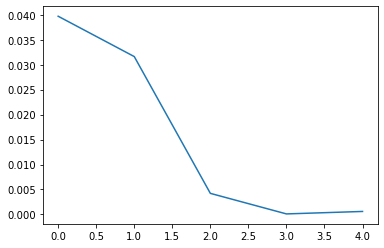

In [102]:
plt.plot(train_loss);

## Test the model

In [103]:
tst_corr = 0
tst_tot = 0

pred_total = []
y_test_total = []

with torch.no_grad():
    for X_test, y_test in test_loader:
        # Apply the model
        y_pred = model(X_test)
        loss = criterion(y_pred, y_test)
        
        # Track accuracy
        tst_tot += X_test.shape[0]
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted==y_test).sum()
        tst_corr += batch_corr
        
        pred_total.append(predicted)
        y_test_total.append(y_test)
        
    print(f'loss = {loss.item():10.8f}\taccuracy = {tst_corr/tst_tot*100:7.3f}%')

loss = 0.00005284	accuracy =  98.760%


In [104]:
y_test_total = torch.concat(y_test_total)
pred_total = torch.concat(pred_total)
cm = confusion_matrix(y_test_total, pred_total)

[Text(0.5, 15.0, 'Predicted'), Text(33.0, 0.5, 'Actual')]

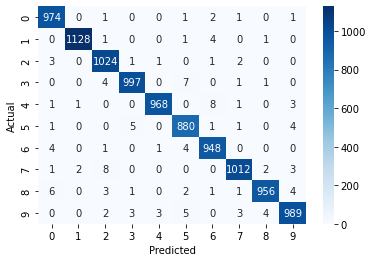

In [105]:
cm_plot = sns.heatmap(cm,annot=True,cmap='Blues',fmt='g')
cm_plot.set(xlabel='Predicted',ylabel='Actual')

# Examine Misses

In [106]:
# Get missed items indexes
missed_idx = np.where(pred_total.numpy()!=y_test_total.numpy())[0]
missed_idx.shape

(124,)

In [107]:
# Setup iterator for verification
row = iter(np.array_split(missed_idx,len(missed_idx)//10))

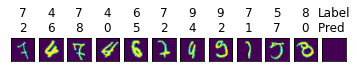

In [109]:
nextrow = next(row)
lab = y_test_total.index_select(0,torch.tensor(nextrow)).numpy()
guess = pred_total.index_select(0,torch.tensor(nextrow)).numpy()
#print("Index:", nextrow)
#print("Label:", lab)
#print("Pred :", guess)

images = test_data.data[nextrow]
fig, axs = plt.subplots(nrows=1, ncols=len(nextrow)+1)
for ax, im, l, g in zip(axs, images, lab, guess):
    ax.imshow(im)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'{l}\n{g}')
ax = axs[-1]
ax.imshow(np.zeros_like(images[0]))
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(f'Label\nPred ');